In [1]:
# This script reads NIH CXR dataset into training, validation, and testing.
## 1. It trains a classification model for normal vs. abnormal
## 2. It then uses the extracted features to compute distance-based metrics

In [2]:
# Import necessary libraries
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.decomposition import PCA
from scipy.linalg import pinv
from PIL import Image
import joblib
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.manifold import TSNE


print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available: 1


In [5]:
# Load the base VGG16 model with pretrained weights
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers for classification
x = Flatten()(base_model.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)  # Assuming binary classification

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])


58889256/58889256 [==============================] - 4s 0us/step


In [7]:
# Define directories for training, validation, and test data
base_dir = "CXR_train_images"
classes = ['Lung Opacity', 'Normal']  # Replace with your actual class names

train_dir = 'CXR_dataset/train'
val_dir = 'CXR_dataset/validation'
test_dir = 'CXR_dataset/test'

# Create directories for each class in the train, validation, and test folders
for cls in classes:
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(val_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(test_dir, cls), exist_ok=True)

def move_files(file_list, source_dir, target_dir):
    """
    Moves a list of files from the source directory to the target directory.
    """
    for f in file_list:
        shutil.move(os.path.join(source_dir, f), os.path.join(target_dir, f))

# Distribute the images into train, validation, and test folders
for cls in classes:
    class_dir = os.path.join(base_dir, cls)
    all_images = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]
    np.random.shuffle(all_images)

    # Split the images into 60% train, 20% validation, and 20% test
    train_split = int(0.6 * len(all_images))
    val_split = train_split + int(0.2 * len(all_images))

    train_images = all_images[:train_split]
    val_images = all_images[train_split:val_split]
    test_images = all_images[val_split:]

    # Move the files to their respective directories
    move_files(train_images, class_dir, os.path.join(train_dir, cls))
    move_files(val_images, class_dir, os.path.join(val_dir, cls))
    move_files(test_images, class_dir, os.path.join(test_dir, cls))

In [8]:
# Define the base directories for train, validation, and test sets
base_dirs = {
    'train': 'CXR_dataset/train',
    'validation': 'CXR_dataset/validation',
    'test': 'CXR_dataset/test'
}

# Define the class names
classes = ['Lung Opacity', 'Normal']  # Replace with your actual class names

# Function to count images in a directory
def count_images(class_dir):
    return sum([len(files) for r, d, files in os.walk(class_dir)])

# Iterate over each set and class and count images
for set_name, base_dir in base_dirs.items():
    print(f"Image count in {set_name} set:")
    for cls in classes:
        class_dir = os.path.join(base_dir, cls)
        image_count = count_images(class_dir)
        print(f" - {cls}: {image_count} images")


Image count in train set:
 - Lung Opacity: 1324 images
 - Normal: 1410 images
Image count in validation set:
 - Lung Opacity: 662 images
 - Normal: 705 images
Image count in test set:
 - Lung Opacity: 1323 images
 - Normal: 1412 images


In [9]:
# Define ImageDataGenerators for data augmentation and preprocessing
train_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)
val_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)

# Create data generators for training and validation sets
train_generator = train_datagen.flow_from_directory(
    directory='CXR_dataset/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary')

validation_generator = val_datagen.flow_from_directory(
    directory='CXR_dataset/validation',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary')


Found 2734 images belonging to 2 classes.
Found 1367 images belonging to 2 classes.


In [ ]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=np.ceil(train_generator.samples / train_generator.batch_size),
    epochs=10,
    validation_data=validation_generator,
    validation_steps=np.ceil(validation_generator.samples / validation_generator.batch_size)
)

# Print the training history
print(history.history)

Epoch 1/10
86/86 [==============================] - 642s 7s/step - loss: 2.4483 - accuracy: 0.8435 - val_loss: 1.6314 - val_accuracy: 0.8683
Epoch 2/10
86/86 [==============================] - 74s 864ms/step - loss: 0.5633 - accuracy: 0.9225 - val_loss: 0.9643 - val_accuracy: 0.8851
Epoch 3/10
86/86 [==============================] - 78s 909ms/step - loss: 0.2730 - accuracy: 0.9532 - val_loss: 0.9422 - val_accuracy: 0.8895
Epoch 4/10
86/86 [==============================] - 79s 920ms/step - loss: 0.1067 - accuracy: 0.9748 - val_loss: 1.1564 - val_accuracy: 0.8786
Epoch 5/10
86/86 [==============================] - 76s 885ms/step - loss: 0.0809 - accuracy: 0.9788 - val_loss: 0.9291 - val_accuracy: 0.8998
Epoch 6/10
86/86 [==============================] - 76s 880ms/step - loss: 0.0708 - accuracy: 0.9813 - val_loss: 0.8483 - val_accuracy: 0.8954
Epoch 7/10
86/86 [==============================] - 75s 869ms/step - loss: 0.0584 - accuracy: 0.9843 - val_loss: 0.8917 - val_accuracy: 0.8947
E

In [10]:
feature_model = Model(inputs=model.input, outputs=model.get_layer('block5_conv3').output)

In [ ]:
def extract_features(generator, model):
    features = []
    labels = []
    for batch, label in generator:
        feature_batch = model.predict(batch)
        features.append(feature_batch)
        labels.append(label)
        if len(features) * generator.batch_size >= generator.samples:
            break
    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    return features, labels

train_features, train_labels = extract_features(train_generator, feature_model)


1/1 [==============================] - 0s 26ms/step


In [ ]:
# Flatten the features for dimensionality reduction
flat_features = train_features.reshape(train_features.shape[0], -1)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
reduced_features = tsne.fit_transform(flat_features)


TSNE: To visualize these high-dimensional features, we can use techniques like PCA (Principal Component Analysis) or t-SNE (t-distributed Stochastic Neighbor Embedding) for dimensionality reduction.

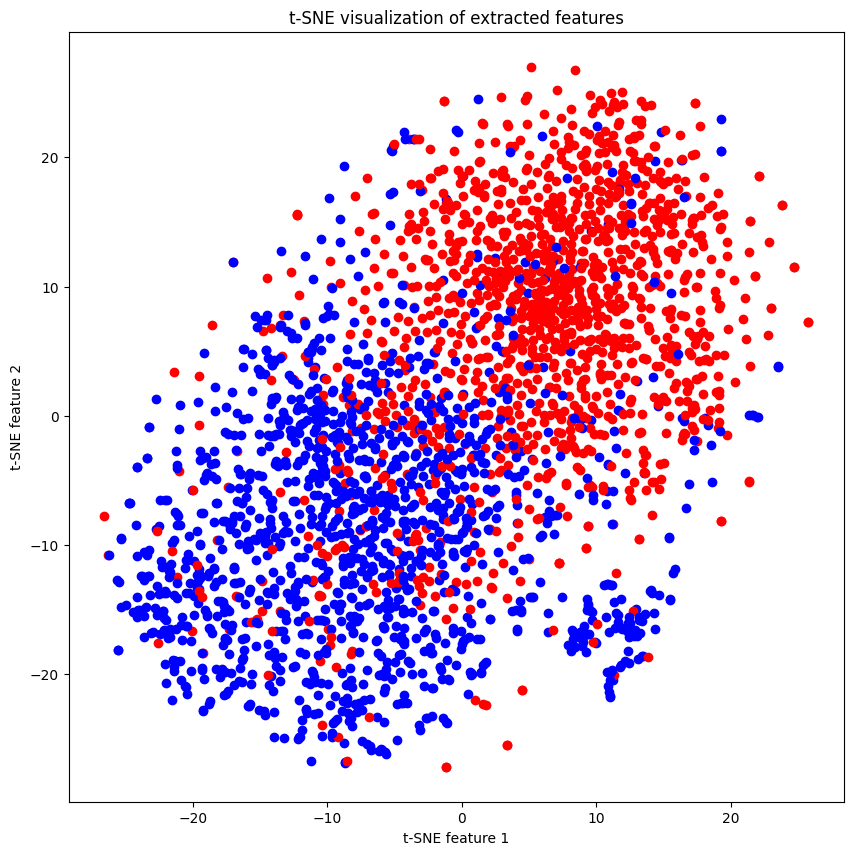

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i in range(len(reduced_features)):
    plt.scatter(reduced_features[i, 0], reduced_features[i, 1],
                c=('red' if train_labels[i] == 0 else 'blue'))  # Change colors as per your class labels
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.title('t-SNE visualization of extracted features')
plt.show()


Principal Component Analysis (PCA):
PCA is a linear dimensionality reduction technique that can be used to visualize high-dimensional data. It's faster than t-SNE but may not be as effective at capturing non-linear relationships.

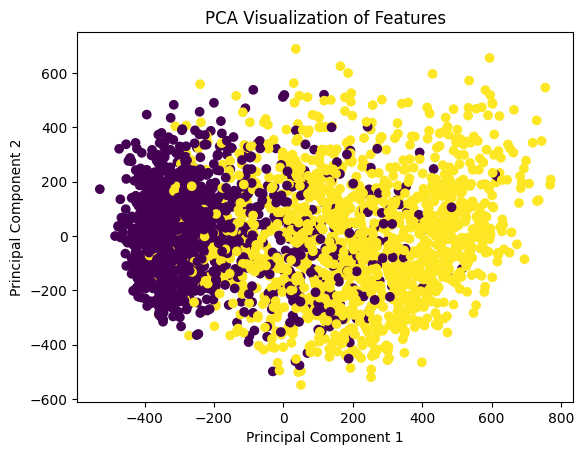

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
pca_result = pca.fit_transform(flat_features)

plt.scatter(pca_result[:, 0], pca_result[:, 1], c=train_labels, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Visualization of Features')
plt.show()


UMAP (Uniform Manifold Approximation and Projection):
UMAP is another dimensionality reduction technique similar to t-SNE but often faster and scalable to larger datasets.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 8.1 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86831 sha256=f142973d69b5085557e52192b265c11b4fa9682c5dbdd24aca8506ab6f62c98f
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn


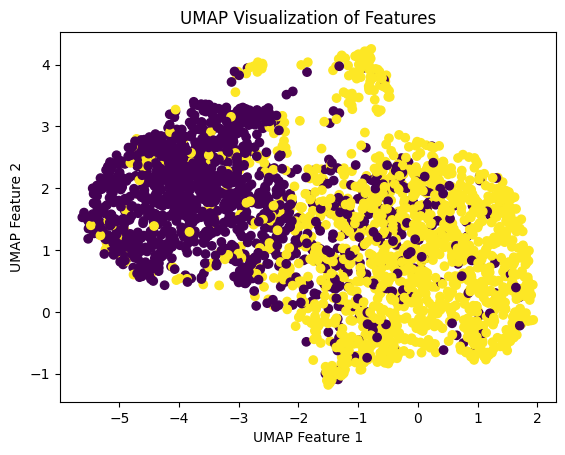

In [ ]:
!pip install umap-learn

import umap
reducer = umap.UMAP()

umap_result = reducer.fit_transform(flat_features)

plt.scatter(umap_result[:, 0], umap_result[:, 1], c=train_labels, cmap='viridis')
plt.xlabel('UMAP Feature 1')
plt.ylabel('UMAP Feature 2')
plt.title('UMAP Visualization of Features')
plt.show()


Save or load the features extractedusing this model as follows.

Flatten the loaded Features:
First, flatten the features if they are not already in a flat (1D) format. This is necessary for most distance computations.

In [ ]:
# Assuming train_features is your array of extracted features
flat_train_features = loaded_features.reshape(loaded_features.shape[0], -1)
print(flat_train_features.shape)

(2734, 100352)
